In [3]:
import pandas as pd
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# To avoid truncating columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Setting random seed for reproducibility
RANDOM_SEED = 1

# Load the Data

In [4]:
train = pd.read_csv("vct_data/train_preprocessed.csv")
train.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,Team B,Team B Score,Team B Attacker Score,Team B Defender Score,Team B Overtime Score,Duration,Rating_TeamA,Average Combat Score_TeamA,Kills_TeamA,Deaths_TeamA,Assists_TeamA,Kills - Deaths (KD)_TeamA,"Kill, Assist, Trade, Survive %_TeamA",Average Damage Per Round_TeamA,Headshot %_TeamA,First Kills_TeamA,First Deaths_TeamA,Kills - Deaths (FKD)_TeamA,Rating_TeamB,Average Combat Score_TeamB,Kills_TeamB,Deaths_TeamB,Assists_TeamB,Kills - Deaths (KD)_TeamB,"Kill, Assist, Trade, Survive %_TeamB",Average Damage Per Round_TeamB,Headshot %_TeamB,First Kills_TeamB,First Deaths_TeamB,Kills - Deaths (FKD)_TeamB,Loadout Value_TeamA,Remaining Credits_TeamA,Type_TeamA,Loadout Value_TeamB,Remaining Credits_TeamB,Type_TeamB,2k_TeamA,3k_TeamA,4k_TeamA,5k_TeamA,1v1_TeamA,1v2_TeamA,1v3_TeamA,1v4_TeamA,1v5_TeamA,Econ_TeamA,Spike Plants_TeamA,Spike Defuses_TeamA,2k_TeamB,3k_TeamB,4k_TeamB,5k_TeamB,1v1_TeamB,1v2_TeamB,1v3_TeamB,1v4_TeamB,1v5_TeamB,Econ_TeamB,Spike Plants_TeamB,Spike Defuses_TeamB,Elimination_TeamA,Detonated_TeamA,Defused_TeamA,Time Expiry (No Plant)_TeamA,Eliminated_TeamA,Defused Failed_TeamA,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB,KDA_TeamA,Clutches_TeamA,First Blood %_TeamA,Attacker Win %_TeamA,Defender Win %_TeamA,Overtime Win %_TeamA,Rating_RollAvg_TeamA,Average Combat Score_RollAvg_TeamA,Average Damage Per Round_RollAvg_TeamA,KDA_RollAvg_TeamA,"Kill, Assist, Trade, Survive %_RollAvg_TeamA",Attacker Win %_RollAvg_TeamA,Defender Win %_RollAvg_TeamA,Overtime Win %_RollAvg_TeamA,First Blood %_RollAvg_TeamA,Headshot %_RollAvg_TeamA,Clutches_RollAvg_TeamA,Econ_RollAvg_TeamA,Recent Win %_TeamA,KDA_TeamB,Clutches_TeamB,First Blood %_TeamB,Attacker Win %_TeamB,Defender Win %_TeamB,Overtime Win %_TeamB,Rating_RollAvg_TeamB,Average Combat Score_RollAvg_TeamB,Average Damage Per Round_RollAvg_TeamB,KDA_RollAvg_TeamB,"Kill, Assist, Trade, Survive %_RollAvg_TeamB",Attacker Win %_RollAvg_TeamB,Defender Win %_RollAvg_TeamB,Overtime Win %_RollAvg_TeamB,First Blood %_RollAvg_TeamB,Headshot %_RollAvg_TeamB,Clutches_RollAvg_TeamB,Econ_RollAvg_TeamB,Recent Win %_TeamB,Team A Map Win %,Team A H2H Win %,Team B Map Win %,Team B H2H Win %,Map_Abyss,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Lotus,Map_Pearl,Map_Split,Map_Sunset,Team A_Encoded,Team B_Encoded,Winner
0,Champions Tour LATAM Stage 1: Challengers 1,Open Qualifier: LAS,Round of 16,Leviatán vs Furious Gaming,Ascent,Leviatán,7,6,1,0,Furious Gaming,13,7,6,0,41.883333,0.992282,186.0,60,76,22,-16,0.701367,119.6,0.250,10,10,0,0.992282,218.4,76,60,25,16,0.701367,132.8,0.190,10,10,0,17518.95592,8480.648076,Full buy: 20k+,17518.95592,8480.648076,Full buy: 20k+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.592817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.592817,0.0,0.0,2.0,1.0,3.0,1.0,9.0,0.0,3.0,1.0,9.0,0.0,3.0,1.0,2.0,1.0,3.0,1.0,1.078947,0.0,0.500000,0.500000,0.125000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.000,0.0,0.0,0.00,0.0,0.000000,0.0,1.683333,0.0,0.500000,0.875000,0.500000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.000,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.551856,0.530307,0
1,Champions Tour LATAM Stage 1: Challengers 1,Open Qualifier: LAS,Round of 16,Leviatán vs Furious Gaming,Ascent,Furious Gaming,13,7,6,0,Leviatán,7,6,1,0,41.883333,0.992282,218.4,76,60,25,16,0.701367,132.8,0.190,10,10,0,0.992282,186.0,60,76,22,-16,0.701367,119.6,0.250,10,10,0,17518.95592,8480.648076,Full buy: 20k+,17518.95592,8480.648076,Full buy: 20k+,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.592817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.592817,0.0,0.0,9.0,0.0,3.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,9.0,0.0,3.0,1.

In [5]:
test = pd.read_csv("vct_data/test_preprocessed.csv")
test.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,Team B,Team B Score,Team B Attacker Score,Team B Defender Score,Team B Overtime Score,Duration,Rating_TeamA,Average Combat Score_TeamA,Kills_TeamA,Deaths_TeamA,Assists_TeamA,Kills - Deaths (KD)_TeamA,"Kill, Assist, Trade, Survive %_TeamA",Average Damage Per Round_TeamA,Headshot %_TeamA,First Kills_TeamA,First Deaths_TeamA,Kills - Deaths (FKD)_TeamA,Rating_TeamB,Average Combat Score_TeamB,Kills_TeamB,Deaths_TeamB,Assists_TeamB,Kills - Deaths (KD)_TeamB,"Kill, Assist, Trade, Survive %_TeamB",Average Damage Per Round_TeamB,Headshot %_TeamB,First Kills_TeamB,First Deaths_TeamB,Kills - Deaths (FKD)_TeamB,Loadout Value_TeamA,Remaining Credits_TeamA,Type_TeamA,Loadout Value_TeamB,Remaining Credits_TeamB,Type_TeamB,2k_TeamA,3k_TeamA,4k_TeamA,5k_TeamA,1v1_TeamA,1v2_TeamA,1v3_TeamA,1v4_TeamA,1v5_TeamA,Econ_TeamA,Spike Plants_TeamA,Spike Defuses_TeamA,2k_TeamB,3k_TeamB,4k_TeamB,5k_TeamB,1v1_TeamB,1v2_TeamB,1v3_TeamB,1v4_TeamB,1v5_TeamB,Econ_TeamB,Spike Plants_TeamB,Spike Defuses_TeamB,Elimination_TeamA,Detonated_TeamA,Defused_TeamA,Time Expiry (No Plant)_TeamA,Eliminated_TeamA,Defused Failed_TeamA,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB,KDA_TeamA,Clutches_TeamA,First Blood %_TeamA,Attacker Win %_TeamA,Defender Win %_TeamA,Overtime Win %_TeamA,Rating_RollAvg_TeamA,Average Combat Score_RollAvg_TeamA,Average Damage Per Round_RollAvg_TeamA,KDA_RollAvg_TeamA,"Kill, Assist, Trade, Survive %_RollAvg_TeamA",Attacker Win %_RollAvg_TeamA,Defender Win %_RollAvg_TeamA,Overtime Win %_RollAvg_TeamA,First Blood %_RollAvg_TeamA,Headshot %_RollAvg_TeamA,Clutches_RollAvg_TeamA,Econ_RollAvg_TeamA,Recent Win %_TeamA,KDA_TeamB,Clutches_TeamB,First Blood %_TeamB,Attacker Win %_TeamB,Defender Win %_TeamB,Overtime Win %_TeamB,Rating_RollAvg_TeamB,Average Combat Score_RollAvg_TeamB,Average Damage Per Round_RollAvg_TeamB,KDA_RollAvg_TeamB,"Kill, Assist, Trade, Survive %_RollAvg_TeamB",Attacker Win %_RollAvg_TeamB,Defender Win %_RollAvg_TeamB,Overtime Win %_RollAvg_TeamB,First Blood %_RollAvg_TeamB,Headshot %_RollAvg_TeamB,Clutches_RollAvg_TeamB,Econ_RollAvg_TeamB,Recent Win %_TeamB,Team A Map Win %,Team A H2H Win %,Team B Map Win %,Team B H2H Win %,Map_Abyss,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Lotus,Map_Pearl,Map_Split,Map_Sunset,Team A_Encoded,Team B_Encoded,Winner
0,Champions Tour 2024: Pacific Kickoff,Group Stage,Opening (A),T1 vs BLEED,Breeze,T1,18,6,6,6,BLEED,16,6,6,4,202.516667,1.104,214.6,126,116,36,10,0.724,145.2,0.292,15,19,-4,0.850,192.6,116,126,40,-10,0.730,125.6,0.266,19,15,4,19458.823529,4994.117647,Full buy: 20k+,20517.647059,5367.647059,Full buy: 20k+,28.0,4.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,45.8,14.0,6.0,22.0,5.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,37.4,13.0,6.0,11.0,1.0,6.0,0.0,7.0,3.0,6.0,0.0,7.0,3.0,6.0,0.0,11.0,1.0,6.0,0.0,1.396552,2.0,0.441176,0.500000,0.500000,0.6,0.9476,189.04,123.16,1.261334,0.6620,0.557576,0.433333,0.00,0.454615,0.2740,2.2,47.00,0.4,1.238095,5.0,0.558824,0.500000,0.500000,0.4,1.0024,203.16,133.12,1.431985,0.7352,0.533333,0.415152,0.0000,0.487308,0.2480,2.0,53.20,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625044,0.438879,1
1,Champions Tour 2024: Pacific Kickoff,Group Stage,Opening (A),T1 vs BLEED,Breeze,BLEED,16,6,6,4,T1,18,6,6,6,202.516667,0.850,192.6,116,126,40,-10,0.730,125.6,0.266,19,15,4,1.104,214.6,126,116,36,10,0.724,145.2,0.292,15,19,-4,20517.647059,5367.647059,Full buy: 20k+,19458.823529,4994.117647,Full buy: 20k+,22.0,5.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,37.4,13.0,6.0,28.0,4.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,45.8,14.0,6.0,7.0,3.0,6.0,0.0,11.0,1.0,6.0,0.0,11.0,1.0,6.0,0.0,7.0,3.0,6.0,0.0,1.238095,5.0,0.558824,0.500000,0.500000,0.4,1.0024,203.16,133.12,1.431985,

# Data Preprocessing

## Extract features and target

In [6]:
features = [
    "Team A_Encoded", 
    "Team B_Encoded",

    "Team A H2H Win %",
    "Team B H2H Win %",

    "Recent Win %_TeamA",
    "Recent Win %_TeamB",

    "Map_Abyss",
    "Map_Ascent",
    "Map_Bind",
    "Map_Breeze",
    "Map_Fracture",
    "Map_Haven",
    "Map_Icebox",
    "Map_Lotus",
    "Map_Pearl",
    "Map_Split",
    "Map_Sunset",

    "Team A Map Win %",
    "Team B Map Win %",

    "Attacker Win %_RollAvg_TeamA",
    "Attacker Win %_RollAvg_TeamB",

    "Defender Win %_RollAvg_TeamA",
    "Defender Win %_RollAvg_TeamB",

    "Overtime Win %_RollAvg_TeamA",
    "Overtime Win %_RollAvg_TeamB",

    "Rating_RollAvg_TeamA",
    "Rating_RollAvg_TeamB",

    "Average Combat Score_RollAvg_TeamA",
    "Average Combat Score_RollAvg_TeamB", 

    "Average Damage Per Round_RollAvg_TeamA",
    "Average Damage Per Round_RollAvg_TeamB",

    "KDA_RollAvg_TeamA",
    "KDA_RollAvg_TeamB",

    "Kill, Assist, Trade, Survive %_RollAvg_TeamA", 
    "Kill, Assist, Trade, Survive %_RollAvg_TeamB",

    "First Blood %_RollAvg_TeamA",
    "First Blood %_RollAvg_TeamB",

    "Headshot %_RollAvg_TeamA",
    "Headshot %_RollAvg_TeamB",

    "Clutches_RollAvg_TeamA",
    "Clutches_RollAvg_TeamB",

    "Econ_RollAvg_TeamA",
    "Econ_RollAvg_TeamB",

]

X_train = train[features]
y_train = train["Winner"]

X_test = test[features]
y_test = test["Winner"]

In [7]:
X_train.head()

,Team A_Encoded,Team B_Encoded,Team A H2H Win %,Team B H2H Win %,Recent Win %_TeamA,Recent Win %_TeamB,Map_Abyss,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Lotus,Map_Pearl,Map_Split,Map_Sunset,Team A Map Win %,Team B Map Win %,Attacker Win %_RollAvg_TeamA,Attacker Win %_RollAvg_TeamB,Defender Win %_RollAvg_TeamA,Defender Win %_RollAvg_TeamB,Overtime Win %_RollAvg_TeamA,Overtime Win %_RollAvg_TeamB,Rating_RollAvg_TeamA,Rating_RollAvg_TeamB,Average Combat Score_RollAvg_TeamA,Average Combat Score_RollAvg_TeamB,Average Damage Per Round_RollAvg_TeamA,Average Damage Per Round_RollAvg_TeamB,KDA_RollAvg_TeamA,KDA_RollAvg_TeamB,"Kill, Assist, Trade, Survive %_RollAvg_TeamA","Kill, Assist, Trade, Survive %_RollAvg_TeamB",First Blood %_RollAvg_TeamA,First Blood %_RollAvg_TeamB,Headshot %_RollAvg_TeamA,Headshot %_RollAvg_TeamB,Clutches_RollAvg_TeamA,Clutches_RollAvg_TeamB,Econ_RollAvg_TeamA,Econ_RollAvg_TeamB
0,0.551856,0.530307,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000
1,0.469694,0.448144,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000
2,0.551856,0.530307,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.875,0.125,0.500,0.0,0.0,0.992282,0.992282,186.0,218.4,119.6,132.8,1.078947,1.683333,0.701367,0.701367,0.5,0.5,0.25,0.19,0.0,0.0,53.592817,53.592817
3,0.469694,0.448144,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.875,0.500,0.500,0.125,0.0,0.0,0.992282,0.992282,218.4,186.0,132.8,119.6,1.683333,1.078947,0.701367,0.701367,0.5,0.5,0.19,0.25,0.0,0.0,53.592817,53.592817
4,0.000000,0.389147,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.000000,0.000000


In [8]:
X_train.shape

(48414, 43)

In [9]:
X_test.head()

,Team A_Encoded,Team B_Encoded,Team A H2H Win %,Team B H2H Win %,Recent Win %_TeamA,Recent Win %_TeamB,Map_Abyss,Map_Ascent,Map_Bind,Map_Breeze,Map_Fracture,Map_Haven,Map_Icebox,Map_Lotus,Map_Pearl,Map_Split,Map_Sunset,Team A Map Win %,Team B Map Win %,Attacker Win %_RollAvg_TeamA,Attacker Win %_RollAvg_TeamB,Defender Win %_RollAvg_TeamA,Defender Win %_RollAvg_TeamB,Overtime Win %_RollAvg_TeamA,Overtime Win %_RollAvg_TeamB,Rating_RollAvg_TeamA,Rating_RollAvg_TeamB,Average Combat Score_RollAvg_TeamA,Average Combat Score_RollAvg_TeamB,Average Damage Per Round_RollAvg_TeamA,Average Damage Per Round_RollAvg_TeamB,KDA_RollAvg_TeamA,KDA_RollAvg_TeamB,"Kill, Assist, Trade, Survive %_RollAvg_TeamA","Kill, Assist, Trade, Survive %_RollAvg_TeamB",First Blood %_RollAvg_TeamA,First Blood %_RollAvg_TeamB,Headshot %_RollAvg_TeamA,Headshot %_RollAvg_TeamB,Clutches_RollAvg_TeamA,Clutches_RollAvg_TeamB,Econ_RollAvg_TeamA,Econ_RollAvg_TeamB
0,0.625044,0.438879,0.0,0.0,0.4,0.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.557576,0.533333,0.433333,0.415152,0.00,0.0000,0.9476,1.0024,189.04,203.16,123.16,133.12,1.261334,1.431985,0.6620,0.7352,0.454615,0.487308,0.2740,0.2480,2.2,2.0,47.00,53.20
1,0.561121,0.374956,0.0,0.0,0.4,0.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.533333,0.557576,0.415152,0.433333,0.00,0.0000,1.0024,0.9476,203.16,189.04,133.12,123.16,1.431985,1.261334,0.7352,0.6620,0.487308,0.454615,0.2480,0.2740,2.0,2.2,53.20,47.00
2,0.625044,0.438879,0.0,0.0,0.6,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.607576,0.483333,0.450000,0.448485,0.12,0.0800,1.0032,0.9604,198.64,201.44,129.88,131.28,1.360397,1.376972,0.6888,0.7312,0.462851,0.474072,0.2736,0.2528,2.4,2.6,47.28,49.84
3,0.561121,0.374956,0.0,0.0,0.2,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.483333,0.607576,0.448485,0.450000,0.08,0.1200,0.9604,1.0032,201.44,198.64,131.28,129.88,1.376972,1.360397,0.7312,0.6888,0.474072,0.462851,0.2528,0.2736,2.6,2.4,49.84,47.28
4,0.574527,0.456347,0.0,0.0,0.4,0.8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.353680,0.483333,0.483333,0.507143,0.00,0.0875,0.9428,0.9816,189.44,194.16,122.92,128.76,1.445625,1.450438,0.6992,0.7100,0.458196,0.402105,0.2400,0.2608,1.2,2.0,50.48,48.80


In [10]:
X_test.shape

(2208, 43)

## Scaling features (for Logistic Regression only)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Selection

We will be using the following models:
- Logistic Regression
- Random Forest
- XGBoost

# Model Training, Validation, and Testing

Functions for cross validating and testing the models

In [12]:
SCORING = ["accuracy", "precision", "recall", "f1", "roc_auc"]

def evaluate_model(model, X_train, y_train, cv=5, scoring=SCORING):
    tscv = TimeSeriesSplit(n_splits=cv)
    scores = cross_validate(model, X_train, y_train, cv=tscv, scoring=scoring)

    for metric in SCORING:
        print(f"{metric}: {scores[f'test_{metric}'].mean()}")
    

def test_model(model, X_train, y_train, X_test, y_test):
    # Train model on full training set
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

## Training baseline models

In [11]:
logreg_base = LogisticRegression(random_state=RANDOM_SEED)
rf_base = RandomForestClassifier(random_state=RANDOM_SEED)
xgb_base = XGBClassifier(random_state=RANDOM_SEED)

In [ ]:

print("Logistic Regression Baseline")
evaluate_model(logreg_base, X_train_scaled, y_train)

In [ ]:
print("Random Forest Baseline")
evaluate_model(rf_base, X_train, y_train)

In [ ]:
print("XGBoost Baseline")
evaluate_model(xgb_base, X_train, y_train)

## Hyperparameter tuning

In [11]:
# Ensures the splits are in chronological order
tscv = TimeSeriesSplit(n_splits=5)

ITERATIONS = 100

# Number of CPU cores to use (-1 means for all cores)
N_JOBS = -1

### Randomized Search

In [ ]:
# Hyperparameter grids for each model
log_reg_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "max_iter": [100, 200, 300, 400, 500, 1000]
}

rf_params = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "max_depth": [None, 5, 10, 15, 20, 25, 30, 50, 100],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

xgb_params = {
    "n_estimators": [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "learning_rate": [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.01, 0.1, 0.5, 1, 1.5, 2, 5, 10],
    "reg_alpha": [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    "reg_lambda": [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
}

# Initialize models
log_reg_tuned = RandomizedSearchCV(LogisticRegression(random_state=RANDOM_SEED), 
                                   log_reg_params, 
                                   n_iter=ITERATIONS, 
                                   cv=tscv, 
                                   scoring=SCORING,
                                   refit="roc_auc", 
                                   random_state=RANDOM_SEED, 
                                   n_jobs=N_JOBS,
                                   error_score="raise")

rf_tuned = RandomizedSearchCV(RandomForestClassifier(random_state=RANDOM_SEED),
                              rf_params,
                              n_iter=ITERATIONS,
                              cv=tscv,
                              scoring=SCORING,
                              refit="roc_auc",
                              random_state=RANDOM_SEED,
                              n_jobs=N_JOBS,
                              error_score="raise")

xgb_tuned = RandomizedSearchCV(XGBClassifier(random_state=RANDOM_SEED),
                               xgb_params,
                               n_iter=ITERATIONS,
                               cv=tscv,
                               scoring=SCORING,
                               refit="roc_auc",
                               random_state=RANDOM_SEED,
                               n_jobs=N_JOBS,
                               error_score="raise")


# Fit models
log_reg_tuned.fit(X_train_scaled, y_train)
rf_tuned.fit(X_train, y_train)
xgb_tuned.fit(X_train, y_train)

print("Models have been trained")

In [ ]:
# Show best parameters
print("Logistic Regression Tuned")
print("Best params:", log_reg_tuned.best_params_)
print("Best score (ROC-AUC):", log_reg_tuned.best_score_)

print("\nRandom Forest Tuned")
print("Best params:", rf_tuned.best_params_)
print("Best score (ROC-AUC):", rf_tuned.best_score_)

print("\nXGBoost Tuned")
print("Best params:", xgb_tuned.best_params_)
print("Best score (ROC-AUC):", xgb_tuned.best_score_)

In [ ]:
print("Logistic Regression Tuned")
evaluate_model(log_reg_tuned.best_estimator_, X_train_scaled, y_train)

In [ ]:
print("Random Forest Tuned")
evaluate_model(rf_tuned.best_estimator_, X_train, y_train)

In [ ]:
print("XGBoost Tuned")
evaluate_model(xgb_tuned.best_estimator_, X_train, y_train)

### Optuna

In [12]:
# Random Forest Tuning
def tune_rf(X_train, y_train, tscv, scoring, random_state, n_iter=100):
    
    def rf_objective(trial):
        rf_params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 5, 50),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 32),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 32),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        }

        rf = RandomForestClassifier(random_state=random_state, n_jobs=-1, bootstrap=True, **rf_params)
        scores = cross_val_score(rf, X_train, y_train, cv=tscv, scoring=scoring)
        return scores.mean()
    
    study = optuna.create_study(direction="maximize")
    study.optimize(rf_objective, n_trials=n_iter)
    return study.best_params, study.best_value


# Tune model
rf_params_optuna, rf_score_optuna = tune_rf(X_train, y_train, tscv, "roc_auc", RANDOM_SEED)

# Display results
print("\nRandom Forest Optuna Tuned")
print("Best params:", rf_params_optuna)
print("Best score:", rf_score_optuna)


[I 2024-09-20 15:25:53,693] A new study created in memory with name: no-name-44b1e746-df66-4bdf-87ca-7e3d2c5c6fc1
[I 2024-09-20 15:28:11,190] Trial 0 finished with value: 0.7184388644477332 and parameters: {'n_estimators': 770, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 17, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.7184388644477332.
[I 2024-09-20 15:28:51,501] Trial 1 finished with value: 0.7193974205621485 and parameters: {'n_estimators': 787, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.7193974205621485.
[I 2024-09-20 15:29:17,985] Trial 2 finished with value: 0.7206642116974736 and parameters: {'n_estimators': 980, 'max_depth': 45, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.7206642116974736.
[I 2024-09-20 15:29:29,690] Trial 3 finished with value: 0.7213582995590763


Random Forest Optuna Tuned
Best params: {'n_estimators': 425, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 32, 'max_features': 'sqrt', 'bootstrap': False}
Best score: 0.7217497491888956

XGBoost Optuna Tuned
Best params: {'n_estimators': 853, 'learning_rate': 0.0067671598523630205, 'max_depth': 5, 'subsample': 0.7618915050496687, 'colsample_bytree': 0.4281007814683212, 'gamma': 1.8775361932428578, 'reg_alpha': 0.12188367911616071, 'reg_lambda': 0.825967031229092}
Best score: 0.7266462761692896


In [ ]:
# XGBoost Tuning
def tune_xgb(X_train, y_train, tscv, scoring, random_state, n_iter=100):
    
    def xgb_objective(trial):
        xgb_params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-5, 10.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-5, 10.0, log=True)
        }

        xgb = XGBClassifier(random_state=random_state, n_jobs=-1, **xgb_params)
        scores = cross_val_score(xgb, X_train, y_train, cv=tscv, scoring=scoring)
        return scores.mean()
    
    study = optuna.create_study(direction="maximize")
    study.optimize(xgb_objective, n_trials=n_iter)
    return study.best_params, study.best_value

# Tune model
xgb_params_optuna, xgb_score_optuna = tune_xgb(X_train, y_train, tscv, "roc_auc", RANDOM_SEED)

# Display results
print("\nXGBoost Optuna Tuned")
print("Best params:", xgb_params_optuna)
print("Best score:", xgb_score_optuna)

In [14]:
rf_tuned_optuna = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, **rf_params_optuna)
xgb_tuned_optuna = XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1, **xgb_params_optuna)

print("Random Forest Optuna Tuned")
evaluate_model(rf_tuned_optuna, X_train, y_train)

print("\nXGBoost Optuna Tuned")
evaluate_model(xgb_tuned_optuna, X_train, y_train)

Random Forest Optuna Tuned
accuracy: 0.654405750402776
precision: 0.6528209344118705
recall: 0.6600721377584214
f1: 0.6563616803942066
roc_auc: 0.7217497491888956
XGBoost Optuna Tuned
accuracy: 0.6574792415417028
precision: 0.6584842445587319
recall: 0.6554114807285533
f1: 0.6567724219256162
roc_auc: 0.7266462761692896


## Model Stacking

In [25]:
def tune_logreg(X_train, y_train, tscv, scoring, random_state, n_iter=100):

    def logreg_objective(trial):
        logreg_params = {
            "C": trial.suggest_float("C", 1e-5, 100, log=True),
            "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
            "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        }

        logreg = LogisticRegression(random_state=random_state, max_iter=2000, **logreg_params)
        scores = cross_val_score(logreg, X_train, y_train, cv=tscv, scoring=scoring)
        return scores.mean()
    
    study = optuna.create_study(direction="maximize")
    study.optimize(logreg_objective, n_trials=n_iter)
    return study.best_params, study.best_value


# Tune model
logreg_params_optuna, logreg_score_optuna = tune_logreg(X_train_scaled, y_train, tscv, "roc_auc", RANDOM_SEED)

# Display results
print("Logistic Regression Optuna Tuned")
print("Best params:", logreg_params_optuna)
print("Best score:", logreg_score_optuna)

[I 2024-09-20 18:45:33,465] A new study created in memory with name: no-name-412b2b2d-26c4-4a56-b7c3-292cdac6471d
[I 2024-09-20 18:45:34,344] Trial 0 finished with value: 0.7009885674370084 and parameters: {'C': 0.012920890828434707, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7009885674370084.
[I 2024-09-20 18:45:35,549] Trial 1 finished with value: 0.6970623307831388 and parameters: {'C': 1.4245940090027496e-05, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.7009885674370084.
[I 2024-09-20 18:45:38,031] Trial 2 finished with value: 0.6916394783129031 and parameters: {'C': 1.0873325703041186, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7009885674370084.
[I 2024-09-20 18:45:38,842] Trial 3 finished with value: 0.6997329760235027 and parameters: {'C': 0.00010012292542418676, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.7009885674370084.
[I 2024-09-20 18:45:41,768] Trial 4 finished with val

Logistic Regression Optuna Tuned
Best params: {'C': 0.002223902796826195, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.7013693825531311


In [34]:
# Level 1 models that train on the train set
base_models = [
    ("rf", rf_tuned_optuna),
    ("xgb", xgb_tuned_optuna)
]

# Trains on the predictions of the base models
meta_model = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
# meta_model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, **rf_params_optuna)
# meta_model = XGBClassifier(random_state=RANDOM_SEED, **xgb_params_optuna)

# Leverages the predictions of the base models to improve predictive performance
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, n_jobs=-1)

print("Stacking Classifier")
evaluate_model(stacking_model, X_train, y_train)

Stacking Classifier
accuracy: 0.6578262486057752
precision: 0.6574409122818297
recall: 0.6597242890204023
f1: 0.6584009327517693
roc_auc: 0.7266101827158127


## Neural Network

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


# Define model architecture
def valornet(input_shape):
    model = Sequential()

    model.add(Input(shape=(input_shape,)))

    model.add(Dense(128, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(32, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(1, activation="sigmoid"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy", tf.keras.metrics.AUC()])
    return model


# Initialize model
valornet = valornet(X_train.shape[1])

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

# Train model
history = valornet.fit(X_train_scaled, y_train,
                       validation_data=(X_test_scaled, y_test), 
                       epochs=50, 
                       batch_size=64, 
                       verbose=1,
                       callbacks=[early_stopping])


Epoch 1/50
757/757 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5471 - auc_4: 0.5649 - loss: 0.8692 - val_accuracy: 0.5389 - val_auc_4: 0.5524 - val_loss: 0.7202
Epoch 2/50
757/757 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5962 - auc_4: 0.6361 - loss: 0.7172 - val_accuracy: 0.5340 - val_auc_4: 0.5511 - val_loss: 0.7122
Epoch 3/50
757/757 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5984 - auc_4: 0.6427 - loss: 0.6927 - val_accuracy: 0.5389 - val_auc_4: 0.5589 - val_loss: 0.7005
Epoch 4/50
757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6139 - auc_4: 0.6607 - loss: 0.6719 - val_accuracy: 0.5340 - val_auc_4: 0.5614 - val_loss: 0.6980
Epoch 5/50
757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6213 - auc_4: 0.6718 - loss: 0.6570 - val_accuracy: 0.5344 - val_auc_4: 0.5642 - val_loss: 0.6955
Epoch 6/50
757/757 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6248 - auc_4: 0.6741 - loss: 0.6538 - val_accuracy: 0.5394 - val_auc_4: 0.5662 - val_loss: 0.6943
Epoch 7/50
757/7

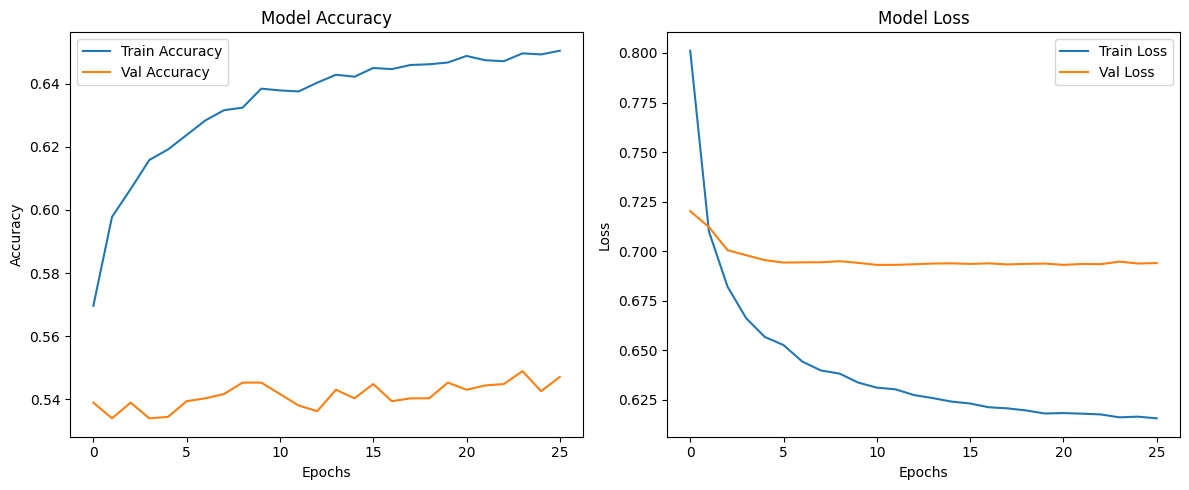

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the training history
plot_training_history(history)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step


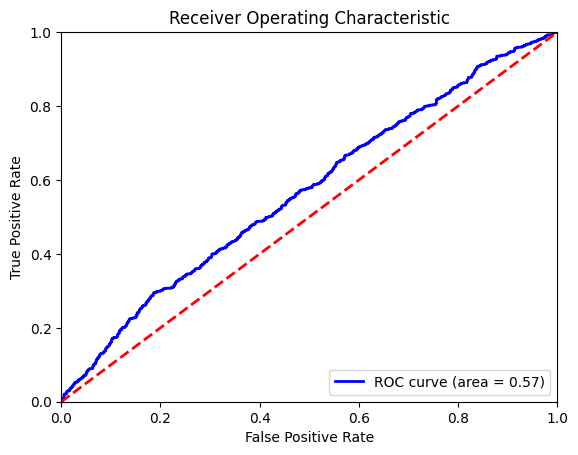

In [35]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, valornet.predict(X_test_scaled))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [37]:
# Get predicted probabilities for Team A winning (class 1)
y_pred_proba = valornet.predict(X_test_scaled)

# Convert probabilities to class labels
y_pred_class = (y_pred_proba > 0.5).astype(int)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step
Accuracy: 0.5416666666666666
Precision: 0.54070796460177
Recall: 0.5534420289855072
F1 Score: 0.5470008952551477
ROC AUC: 0.5677727401018693


## Feature selection

### Tree-based feature importance (Random Forest and XGBoost)

In [20]:
# # Train Random Forest and XGBoost and get feature importances
# rf_base.fit(X_train, y_train)
# xgb_base.fit(X_train, y_train)

# # Get feature importances
# rf_importances = rf_base.feature_importances_
# xgb_importances = xgb_base.feature_importances_

# # Combine feature importances into a DataFrame
# feature_names = X_train.columns
# feature_importances = pd.DataFrame({
#     'Feature': feature_names,
#     'RandomForest_Importance': rf_importances,
#     'XGBoost_Importance': xgb_importances
# })



In [21]:
# # Select top 20 features based on Random Forest
# top_features_rf = feature_importances.nlargest(20, 'RandomForest_Importance')['Feature']
# X_train_rf_top = X_train[top_features_rf]
# X_test_rf_top = X_test[top_features_rf]

In [22]:
# # Sort by importance (Random Forest)
# feature_importances.sort_values(by='RandomForest_Importance', ascending=False, inplace=True)
# feature_importances.head(20)

In [23]:
# Sort by importance (XGBoost)
# feature_importances.sort_values(by='XGBoost_Importance', ascending=False, inplace=True)
# feature_importances.head(20)

### L1 regularization (Logistic Regression)

In [24]:
# logreg_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
# logreg_l1.fit(X_train, y_train)

# # Select important features (non-zero coefficients)
# model = SelectFromModel(logreg_l1, prefit=True)
# X_train_l1 = model.transform(X_train)
# X_test_l1 = model.transform(X_test)

# # Check which features were selected
# selected_features = X_train.columns[(logreg_l1.coef_ != 0).ravel()]
# for feature in selected_features:
#     print(feature)

### Recusive Feature Elimination

In [25]:
# # Apply RFE with Logistic Regression as the estimator
# rfe = RFE(estimator=logreg_base, n_features_to_select=20, step=1)
# rfe.fit(X_train_scaled, y_train)

# # Transform the dataset with selected features
# X_train_rfe = rfe.transform(X_train)
# X_test_rfe = rfe.transform(X_test)

# print("Selected Features by RFE:", X_train.columns[rfe.support_])

In [26]:
# # Apply RFE with Logistic Regression as the estimator
# rfe = RFE(estimator=rf_base, n_features_to_select=20, step=1)
# rfe.fit(X_train, y_train)

# # Transform the dataset with selected features
# X_train_rfe = rfe.transform(X_train)
# X_test_rfe = rfe.transform(X_test)

# print("Selected Features by RFE:", X_train.columns[rfe.support_])

In [27]:
# X_train.head()